In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd

# Monte Carlo Motivation #
Typically we will have some probability distribution $P(x) = \frac{P^*(x)}{Z}$ that we are interested in computing (x is the parameters) 
but the _partition function_ (Z) is intractable. 
In these situations we can typically calculate P* , we don't know Z but it would be of interest if we could find it out (model comparison for ex)

Typically when you are looking to find a posterior distribution, the numerator is P* and tractable, but the denominator i.e. the normalizing constant 
is a complicated multi-dimensional integral that we don't know. 

More precisely, we can define $P^*(x)$ as $e^-{E(x)}$ where we can evaluate $E(x)$ at any point. 
We are typically then interested in:
1) Draw samples from P (**sampling parameters for the true dist given data)
2) Estimate expectations of functions under P $\phi = \sum_x \phi(x)P(x)$

For example, if we want to know how probable it is that the distributions mean is in some range, we can use the posterior probabilities of the means 
and then average the function that is 1 if x in range or 0 otherwise. 

### Importance Sampling & Rejection Sampling ### 
Many MC methods need __Proposal Densities__  $Q$ which is some density that we _can_ sample from. 
Assume we have a function phi(x) and we want to know the expectation of it under our unnormalized dist P*(x)

How can we do this? One idea is to sample x from $Q$ and then calculate $\phi(x)$ at each of these points and average them. 
This would give us  $\phi(x)$ under $Q$ which is not what we want, but if we weight each point by $\frac{P^*(x)}{Q(x)}$ (and adjust our normalizing constant) then we are essentially 
upweighting points where $P*$ is more likely than $Q$ and vice versa. This is technique is known as __Importance Sampling__

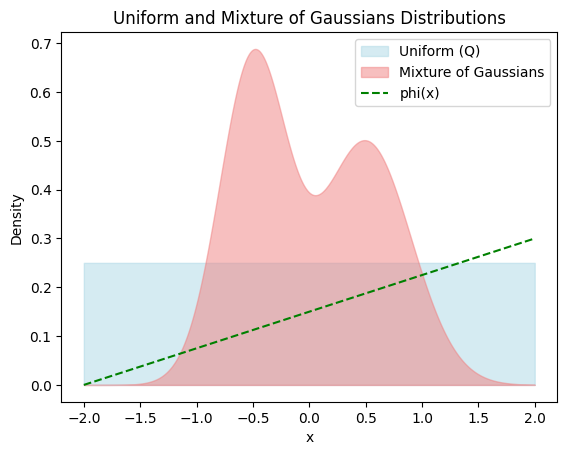

In [7]:


# Define the x-axis values
x = np.linspace(-2, 2, 1000)

# Define the parameters for the two Gaussian distributions
mean1 = -0.5
std1 = 0.3
mean2 = 0.5
std2 = 0.4

# Create the mixture of two Gaussian distributions
gaussian1 = stats.norm.pdf(x, mean1, std1)
gaussian2 = stats.norm.pdf(x, mean2, std2)
mixture = 0.5 * gaussian1 + 0.5 * gaussian2

# Plot the uniform distribution in light blue
plt.fill_between(x, stats.uniform.pdf(x, loc=-2, scale=4), color='lightblue', alpha=0.5, label='Uniform (Q)')

# Plot the mixture of two Gaussian distributions in opaque light red
plt.fill_between(x, mixture, color='lightcoral', alpha=0.5, label='Mixture of Gaussians')
plt.plot([-2, 2], [0, 0.3], color='green', linestyle='--', label='phi(x)')

# Add labels and a legend
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Uniform and Mixture of Gaussians Distributions')
plt.legend()

plt.show()  # Display the plot

### Issues with Importance Sampling ### 
If not obvious from above, this method can run into problems when your proposal distribution $Q$ 
does not look like your target distribution $P*$, and of course a priori we have no idea what $P*$ looks like! 

For example, if you have $Q$ very close to zero, and $P*$ >> 0 then the weight assigned to that point can be massive
and cause spikes in your estimate of expected value of $\phi(x)$. Additionally, during this whole process we never know
__when__ we are close or far away from the true mean, even if we are guaranteed some sort of asymptotic convergence. 

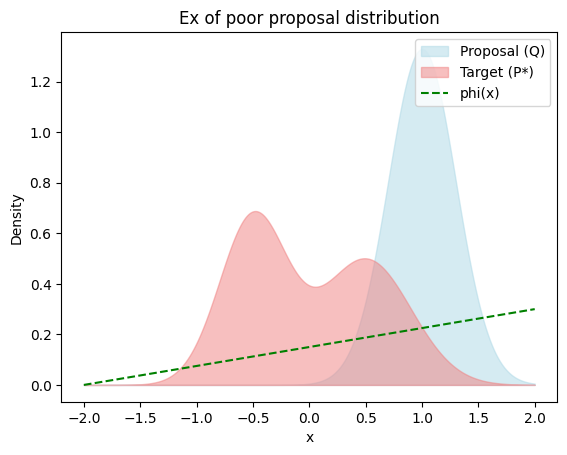

In [12]:
x = np.linspace(-2, 2, 1000)

# Define the parameters for the two Gaussian distributions
mean1 = -0.5
std1 = 0.3
mean2 = 0.5
std2 = 0.4

# Create the mixture of two Gaussian distributions
gaussian1 = stats.norm.pdf(x, mean1, std1)
gaussian2 = stats.norm.pdf(x, mean2, std2)
P = 0.5 * gaussian1 + 0.5 * gaussian2
Q = stats.norm.pdf(x, 1, 0.3)


plt.fill_between(x, Q, color='lightblue', alpha=0.5, label='Proposal (Q)')
plt.fill_between(x, mixture, color='lightcoral', alpha=0.5, label='Target (P*)')
plt.plot([-2, 2], [0, 0.3], color='green', linestyle='--', label='phi(x)')

# Add labels and a legend
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Ex of poor proposal distribution')
plt.legend()

plt.show()  # Display the plot

### Rejection Sampling ### 
The thought process behind rejection sampling is that we have a proposal distribution again $Q(x)$, where we __know__
$cQ(x) > P^*(x) \text{ for some } C \in \mathbb{R}$ 

If we can find such a distribution (which might be hard to do) then we can follow the following steps to sample from $P*(x)$:
1. draw $x'$ from $cQ(x)$
2. Draw from a uniform dist on [0, $cQ(x')$]
3. if u <= P*(x) then ACCEPT this point, otherwise REJECT the point 
4. Repeat

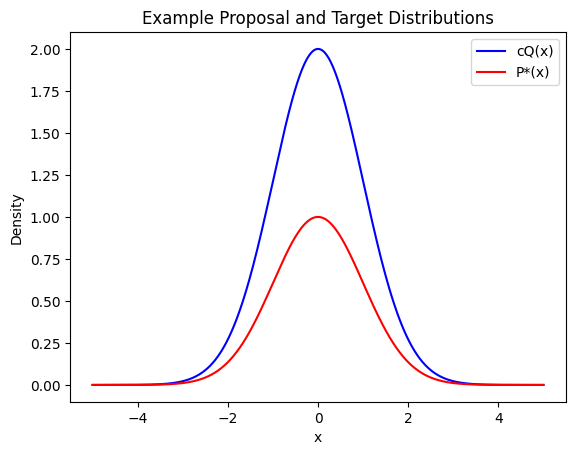

In [19]:
x = np.linspace(-5, 5, 1000)

# Define the two unnormalized distributions
cQ = 2 * np.exp(-0.5 * x**2)
P_star = np.exp(-0.5 * x **2)

# Plot the cQ(x) distribution in blue
plt.plot(x, cQ, color='blue', label='cQ(x)')

# Plot the P*(x) distribution in red
plt.plot(x, P_star, color='red', label='P*(x)')

# Add labels and a legend
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Example Proposal and Target Distributions')
plt.legend()

plt.show()  # Display the plot

### Problems with Rejection Sampling ### 
1. Obviously, it can be hard to arrive at a $cQ(x)$ that is guaranteed to be greater than $P^*(x)$ everywhere
2. even if you _do_ find such a distribution, your distribution needs to be reasonably 'tight' to $P^*(x)$. 
if you just pick some massive c, then you would reject many many points and your sampling might take quite a long time. 

**Aside: probability that a sample is accepted is a geometric r.v. with p = 1 / c, thus
the expected number of samples you have to draw to be accepted is c. Now you can see why we want to find 
the tightest bounded c possible to improve our efficiency! 

## Metropolis Methods and Gibbs Sampling ## 
These methods are examples of _Markov Chain Monte Carlo_ where we keep track of our 'state' by using the previous point
to move to the next. We will still have a proposal distribution that we can sample from, $Q(x ; x')$ but now x represents the next location
and x' represents the current location we are at. 

Importantly, the proposal distribution here does _not_ have to look like $P^*(x)$, which previously was very helpful for 
important sampling and rejection sampling. 

Typically for this method to work, Q will make just a small change to the energy of the system (e.g. $-\log{ P^*(x)}$)

The algorithm for this is as follows:
1. draw an x from $Q(x ; x')$
2. calculate our acceptance ratio: $a = \frac{P^*(x) * Q(x^t ; x)}{P^*(x^t) * Q(x, x^t)}$
    - $Q(x^t ; x)$ is the probability we return to x(t) from point x 
    - if $Q(x^t ; x)$  and $Q(x ; x^t)$  have different normalizing constants, then we need to know them. otherwise 
    they would cancel out 
 3. if a > 1; accept (e.g $x^{t+1}$ is $x$) or if a < 1 accept with probability a 
4. if we reject then x(t+1) = x(t) so we don't move 

Asymptotically, the probability distribution of x(t) is $P(x)$!! The high level intuition: where $P^*(x)$ is large, 
it will be very hard to draw points that higher than that, thus it is _likely_ that you will remain there for your next sample
instead of moving somewhere else on the curve. This forces you to draw more points in these locations, which would make sense if 
you are sampling from $P^*$! 

Let's implement an example: 

In [ ]:
def evaluate_target(x):
    mean1, std1 = -0.5, 0.3
    mean2, std2 = 0.5, 0.4
    gaussian1 = stats.norm.pdf(x, mean1, std1)
    gaussian2 = stats.norm.pdf(x, mean2, std2)
    P = 0.5 * gaussian1 + 0.5 * gaussian2
    return P

x = np.linspace(-5, 5, 1000)
mean = np.random.uniform(-5, 5)
stdev = 0.5

# proposal dist 
Q = stats.norm.pdf(mean, stdev, 0.5)
# target dist 
P = evaluate_target(x)

plt.fill_between(x, Q, color='lightblue', alpha=0.5, label='Proposal (Q)')
plt.fill_between(x, P, color='lightcoral', alpha=0.5, label='Target (P*)')

accepted_points = []
P_old = evaluate_target(mean)
i = 1
while (len(accepted_points) < 10) and (i < 30):
    plt.clf()
    # sample from Q which will be the mean of the next proposal dist
    mean = np.random.normal(mean, stdev)
    P_new = evaluate_target(mean)
    # gaussians cancel out so just need to compare the ratio of the two P's 
    a = P_new / P_old
    if np.random.uniform() < a:  # will always accept a  > 1 
        P_old = P_new
        accepted_points.append(mean)
        plt.axvline(mean, color='green', alpha=0.2)
    else:
        plt.axvline(mean, color='red', alpha=0.2)
    
    Q = stats.norm.pdf(x, mean, stdev)
    plt.title(f"Metropolis sampling at iteration = {i+1}")
    plt.fill_between(x, Q, color='lightblue', alpha=0.5, label=f'Proposal (Q) at step {i}')
    plt.fill_between(x, mixture, color='lightcoral', alpha=0.5, label='Target (P*)')
    plt.scatter(accepted_points, np.full(len(accepted_points), -0.1), color='green', marker='x')  # Plot the accepted points
    plt.legend()
    plt.pause(0.5)
    i += 1 

plt.show()
   

### Problems with Metropolis Method ###
Once again, we know that asymptotically we are drawing from $P(x)$ but we don't know how long
we have to run this in order to get there. It's also important to note that 
we are not producing T independent samples from T iterations, they are dependent on each other! 


### Gibbs Sampling ### 
MCMC method that works in two or more dimensions. For Gibbs sampling, we still obviously cannot draw 
from $P(x)$ _but_ we make the rather large assumption we _can_ draw from a conditional distribution such as $P(x1 | x2)$ in a two dimensional case. 

Algorithm:
1. Starting at $x_1^{t}$, draw $x_1^{t+1}$ from $P(x_1 | x_2^{t})$
2. Then sample $x_2^{t+1}$ using $P(x_2 | x_1^{t+1})$ from step 1
3. Repeat - for k variables, you will need to sample conditional dist for each one 
given all the others. 

Gibbs is a metropolis method, so asymptotically it draws from the correct dist!
And the best part arguably is that there are no tunable parameters. 

Let's implement a quick example, using Gibbs sampling to infer parameters for a gaussian distribution $\mu$ and $\sigma$

In order to sample from the conditional distribution, we will need to draw from 
1. A normal given sigma, to get our steps mu
2. A Gamma dist, given part (1) mu, in order to sample our sigma 

In order to do this we will use the following equations: note that in our Normal Dist we are going to assume a prior of $\mu = 0, \sigma^2 = 1$
, which simplifies the terms with $\mu_0$ and $\tau$. 

$$
\mu | \sigma, x \sim \mathcal{N}\left(\frac{\frac{1}{\sigma^2}\sum_{i=1}^n x_i + \frac{1}{\tau^2}\mu_0}{\frac{n}{\sigma^2} + \frac{1}{\tau^2}}, \frac{1}{\frac{n}{\sigma^2} + \frac{1}{\tau^2}}\right)
$$
$$
\sigma^2 | \mu, x \sim \text{Inverse-Gamma}\left(\alpha + \frac{n}{2}, \beta + \frac{1}{2}\sum_{i=1}^n (x_i - \mu)^2\right)
$$




Starting from mu = 1.6665644975015041 and sigma = 0.3025395977799099
Final estimation of mu = -0.003745473385927407 and sigma = 0.9980710417002419


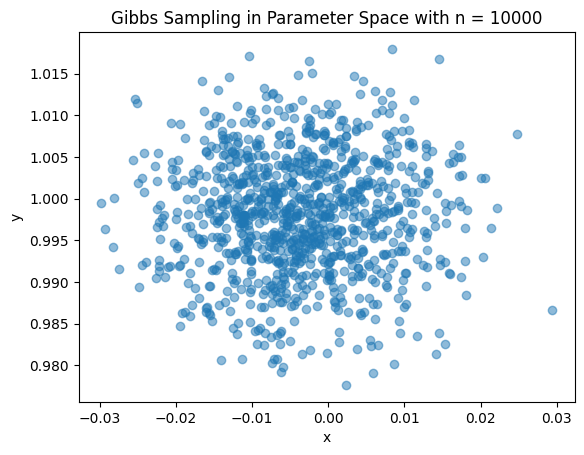

In [71]:
def conditional_gaussian(n, sample_mean, sigma):
    """assume a prior of mu = 0 and sigma = 1"""
    conditional_mean = (sigma**-2 * n * sample_mean) / (n * sigma**-2 + 1)
    conditional_var = 1 / (n * sigma**-2 + 1)
    return stats.norm.rvs(conditional_mean, np.sqrt(conditional_var))
 

def conditional_gamma(data, mu, alpha, beta):
    alpha = alpha + len(data) / 2
    beta = beta + 0.5 * np.sum((data - mu)**2)
    return stats.invgamma.rvs(alpha, scale=beta)
    

def run_gibbs_sampling(iterations, data):
    """
    Perform gibbs sampling for inference of mu and sigma of a normal distribution
    based off of a sample of data. 

    Recall that the conditional distribution of mu given sigma is normal and the
    conditional distribution of sigma given mu is gamma.
    
    """
    alpha, beta = 1, 1
    n = len(data)
    sample_mean = np.mean(data)
    # pick random point for mu and sigma
    mu = np.random.uniform(-2, 2)
    sigma = np.random.uniform(0, 2)
    print(f"Starting from mu = {mu} and sigma = {sigma}")

    samples = np.zeros((iterations, 2))
    samples[0, :] = mu, sigma

    for i in range(1, iterations):
        mu = conditional_gaussian(n, sample_mean, np.sqrt(samples[i-1, 1]))
        sigma_sq = conditional_gamma(data, mu, alpha, beta)
        samples[i, :] = mu, sigma_sq

    return samples

num_samples = 10000
true_mean, true_sigma = 0, 1
data = stats.norm.rvs(true_mean, true_sigma, num_samples)
samples = run_gibbs_sampling(1000, data)
x = samples[1:, 0] # ignore rnadom first sample
y = np.sqrt(samples[1:, 1] )
print(f"Final estimation of mu = {np.mean(x)} and sigma = {np.mean(y)}")

plt.scatter(x, y, alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Gibbs Sampling in Parameter Space with n = {num_samples}')

plt.show()
#

### Toy example with a random walk between two walls ### 
Image in our distribution is uniform between 0 and 20, (we don't know this though and think it's nasty)
and then our proposal is just a coin flip - 50% change we move right 1 step, and 50% chance we move left one step. 
In this setup, our random walk metropolis is clearly dependent - but how long does it take for you to truly draw an independent sample from this? 

Essentially, when you are drawing from a uniform distribution of the points in the space L, then it is an independent sample. Now since 
we are implementing a random walk, this is closely tied with how long it takes us to move around the space. Even in this very simple one dimensional problem where we only move along a line, we are expected to have to take $(\frac{L}{\epsilon})^2$ steps - in this example $\epsilon = 1 $. So if we estimate this as the amount of steps it will take us to get to both walls starting in the middle, we need roughly 400-500 steps to get to one truly independent samples! 

In general, for $\gamma$ dimensions, how big should we make our step size $\epsilon$? 
Well consider the fact that you'd want to take the largest step possible, but without significantly decreasing your probability of acceptance. 
In $\gamma$ dimensions, if your smallest axis of your manifold is length $l$ then you are constrained by this factor as the probability that you
'fall off' the manifold (e.g. sample rejected) grows exponentially with the number of dimensions of $\epsilon$ is too large. 
Thus you want to your step size to match the smallest dimesnion of your manifold, which is given by the minimum eigen value of that data. 

If you can find $\epsilon = l$ then you should get about 50% acceptance 




### Hamiltonian Monte Carlo ### 
An 'efficient' monte carlo method wher we add a __momentum__ variable to increase the problem space and try to sample from this new distribution

$$
P(\vec{x}, \vec{p}) = P(\vec{x}) \times e^{-\frac{1}{2} \frac{\vec{p}^2}{M}}
$$

Recall that $P(\vec{x})$ is of the form $e^{-E(x)}$ so we can now look at it like 
$e^{{-E(x)} + \frac{\vec{p}^2}{M}}$ which breaks down your energy into a _potential_ energy and a _kinetic_ energy term. Now we can do something neat- move around this surface of constant energy (between potential and kinetic) using newton's laws! 

So our high level algorithm:
1. Simulate Newton's Laws (approximately)
2. accept / reject based on whether total energy is conserved 
3. randomize $p$ by sampling from $e^{-\frac{\vec{p}^2}{M}}$
4. repeat


### Overrelaxation ### 
Can be applied from Gibbs sampling models! The high level idea is that 
when you are supposed to draw from a conditional distribution, you don't draw from the actual distribution
but instead one that is biased away from your current point. 

You can use _Adler's method_ if your conditional distribution is Gaussian, where there is a simple rule
to 'squish' your normal and then move it to the appropriate bias (e.g. if you drew a point from the cdf = 20% on the left of the normal, this method might then have you draw from a normal centered at cdf = 80% )

_Ordered Over-relaxation_ is a way to perform this on non-gaussian distributions as well. 
The algorithm is roughly:
1. Draw K points from the conditional distribution 
2. Wherever your current point is, go to the opposite ranked point in the queue 
   - ex. in python, if you are index i, you would go to index my_points[-i]
3. Repeat 


Below we will implement an example of Ordered Over Relaxation on the same example we used for Gibbs sampling. 
It will require just a silght modification to our code:

Final estimation of mu = 0.01673027404955778 and sigma = 0.9698343094173535


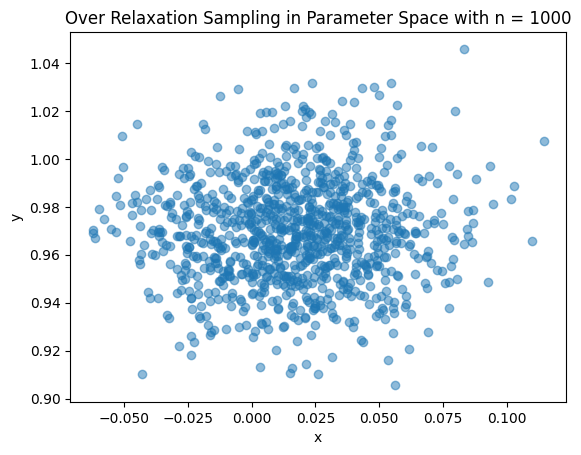

In [91]:
def conditional_gaussian(n, sample_mean, sigma, k):
    """assume a prior of mu = 0 and sigma = 1"""
    conditional_mean = (sigma**-2 * n * sample_mean) / (n * sigma**-2 + 1)
    conditional_var = 1 / (n * sigma**-2 + 1)
    return stats.norm.rvs(conditional_mean, np.sqrt(conditional_var), size=k)
 

def conditional_gamma(data, mu, alpha, beta, k):
    alpha = alpha + len(data) / 2
    beta = beta + 0.5 * np.sum((data - mu)**2)
    return stats.invgamma.rvs(alpha, scale=beta, size=k)

def get_new_sample(parameter_list, current_sample):
    """
    returns inverse location of the current sample in the sorted list of parameters
    ex. for a list [1, 2, 3, 4] and current_sample = 5 returns 1 since 5 is the largest, thus it would choose the 
    smallest element in the list which is 1 
    """
    sorted_idx = np.where(np.sort(np.append(parameter_list, current_sample)) == current_sample)[0][0]    
    return parameter_list[-sorted_idx]
    

def run_ordered_relaxation(iterations, data, k):
    """
    Perform ordered  relaxation of gibbs sampling for inference of mu and sigma of a normal distribution
    based off of a sample of data. 
    """
    alpha, beta = 1, 1
    n = len(data)
    sample_mean = np.mean(data)
    # pick random point for mu and sigma
    mu = np.random.uniform(-2, 2)
    sigma = np.random.uniform(0, 2)
    
    samples = np.zeros((iterations, 2))
    samples[0, :] = mu, sigma

    for i in range(1, iterations):
        current_mu, current_sigma_sq = samples[i-1, :]
        k_mu = conditional_gaussian(n, sample_mean, np.sqrt(samples[i-1, 1]), k)
        k_sigma_sq = conditional_gamma(data, mu, alpha, beta, k)
        mu = get_new_sample(k_mu, current_mu)
        sigma_sq = get_new_sample(k_sigma_sq, current_sigma_sq)
        samples[i, :] = mu, sigma_sq

    return samples

num_samples = 1000
true_mean, true_sigma = 0, 1
data = stats.norm.rvs(true_mean, true_sigma, num_samples)
samples = run_ordered_relaxation(1000, data, 8)
x = samples[5:, 0] # ignore rnadom first sample
y = np.sqrt(samples[5:, 1] )
print(f"Final estimation of mu = {np.mean(x)} and sigma = {np.mean(y)}")

plt.scatter(x, y, alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Over Relaxation Sampling in Parameter Space with n = {num_samples}')

plt.show()
#

### Slice Sampling ### 
This can be implemented one dimension at a time for a K dimensional distribution. 
In the one dimension chosen, the algorithm is as follows:

1. Calculate $s = P^*(x_t)$
2. Draw a point uniformly between [0, s]
3. At this point on the line between x-axis and s, we implement a 'bar' of width w, which is a parameter we will choose. 
4. We then randomly adjust this 'bar' by choosing an offset [-w, w] where -w means we slide all the way to the left at the point, adn vice versa 
5. Now we have two points corresponding to either end of our bar. I'll call them $b_0$ and $b_w$ We calculate $P^*(b_0)$ and $P^*(b_w)$  
6. If $P^*(b_0)$ is above our current location, we then make a step to the left of length w.
Same goes for $P^*(b_w)$ except it would be a step to the right. If the point is below our point, you stop on whatever side that is. 
7. Keep stepping out until both sides have points $P^*(b_0)$ and $P^*(b_w)$ that lie below our line
8. We now draw a candidate point from our 'bar' line and evalute $P^*()$ here. _If_ it is below our current line, we can shrink our bar to this point, and then repeat. If it is above our current line, this now becomes our new point $x_{t+1}$ 

Yes that was a lot. I was confusing myself while writing it out. It's probably best to see this quickly in a diagram

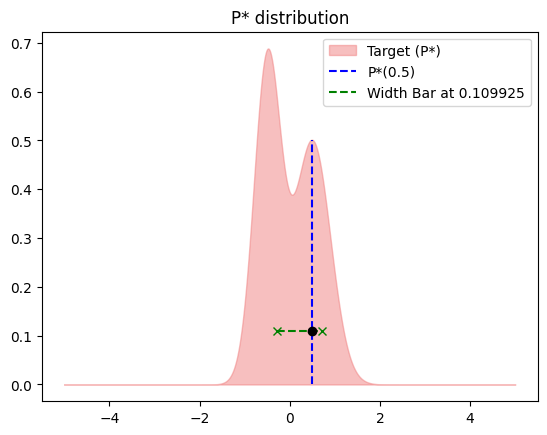

In [125]:
def evaluate_target(x):
    mean1, std1 = -0.5, 0.3
    mean2, std2 = 0.5, 0.4
    gaussian1 = stats.norm.pdf(x, mean1, std1)
    gaussian2 = stats.norm.pdf(x, mean2, std2)
    P = 0.5 * gaussian1 + 0.5 * gaussian2
    return P

# Calculate P*(x_t) and sample uniformly from [0, P*(x_t)]
x = np.linspace(-5, 5, 1000)
# target dist 
P = evaluate_target(x)
assert len(x) == len(P)
plt.fill_between(x, P, color='lightcoral', alpha=0.5, label='Target (P*)')
x_t = 0.5
P_t = evaluate_target(x_t)
u = np.random.uniform(0, P_t)
w = 1  # width parameter of our process 

# randomize offset for the bar
offset = np.random.uniform(-w/2, w/2)
x_offset = x_t + offset

plt.vlines(x=x_t, ymin=0, ymax=P_t, color='blue', linestyles='dashed', label=f'P*({x_t})')
plt.hlines(y=u, xmin=x_offset-w/2, xmax=x_offset + w/2, color='green', linestyles='dashed', label=f'Width Bar at {u:2f}')

plt.plot(x_t, u, 'ko')
plt.plot(x_offset + w/2, u, 'x', color='green')
plt.plot(x_offset - w/2, u, 'x', color = 'green')

plt.title(f"P* distribution")
plt.legend()
plt.show()

From here we would evaluate $P^*$ at both of the green x's. In the above example, we would need to step out on both sides (aka add $w$ length to both ends of our green line) since the we our current point $u$ is below $P^*$ in both cases. 

After stepping out, we would then repeat the evaluation, and assuming we reached a point where $P*$ is below the two ends, we would then pick a random point on that green line. From there we can accept if $P^*$  is above our point $u$! 

It seems like a lot, but the high level intuition is that you are spending more time sampling from areas where the pdf is high. 

In K dimensions, you would need to do a 'step out' algorithm for each of the dimensions so that is something to consider. 

## Exact Sampling ## 
Intuition: You can establish an infinity long computer simulation of sampling
in a finite amount of time. You want to run the simulation from K steps in the past for all possible states in your state space, _using the same random numbers_.  
If the random walk paths converge into a single path, then you have gone far enough back (and any infinite simulation would have arrived at the same point). Since they use the same random numbers, if they converge, they will then be in lock step for the rest of the simulation. 

If not, then go back something like 2 * K  and repeat until the random paths converge. 

The immediate downside is simulating possibly 2^N states. However, in some cases (such as a +1 or -1 random walk) you only need to simulate the _boundary_ starting points, since if these coalesce you know that they all do. 
